# Imports

In [ ]:
from google.colab import drive
import os
import json
from PIL import Image
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
import matplotlib.pyplot as plt
import torch.quantization
import re
import matplotlib.pyplot as plt
import torch.nn.utils.prune as prune
import psutil



In [ ]:
process = psutil.Process()
ram_usage_list = []
ram_baseline = process.memory_info().rss / (1024 * 1024)
print("Baseline RAM usage (MB):", ram_baseline)

# Annotation Loading and Splitting

In [ ]:
# 1) Monta Google Drive
drive.mount('/content/drive')

# 2) Imposta percorsi
ei_export_dir    = "/content/drive/MyDrive/Colab Notebooks/HAEEAI/project/uwb2-export"
labels_file      = os.path.join(ei_export_dir, "info.labels")
images_dir       = ei_export_dir

# 3) Leggi info.labels
with open(labels_file, 'r') as f:
    ei_data = json.load(f)

# 4) Estrai bounding box

original_width = 310
original_height = 308
new_width = 96
new_height = 96

train_annotations = {}
test_annotations = {}

for entry in ei_data.get('files', []):
    rel_path = entry['path']
    boxes = []
    for bb in entry.get('boundingBoxes', []):
        x = bb['x'] * new_width / original_width
        y = bb['y'] * new_height / original_height
        w = bb['width'] * new_width / original_width
        h = bb['height'] * new_height / original_height
        boxes.append((x, y, w, h))

    if rel_path.startswith("training/"):
        train_annotations[rel_path] = boxes
    elif rel_path.startswith("testing/"):
        test_annotations[rel_path] = boxes

# Sauvegarde
with open("annotations_train.json", "w") as f:
    json.dump(train_annotations, f)
with open("annotations_test.json", "w") as f:
    json.dump(test_annotations, f)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Usefull fonction

## Heatmap
Creates a binary heatmap of shape [Hc, Wc] where each 1 represents a cell where an object is present based on the bounding boxes.

In [ ]:
def create_heatmap_centroids(cell_shape, image_shape, boxes):
    Hc, Wc = cell_shape
    h, w = image_shape
    heatmap = np.zeros((Hc, Wc), dtype=np.float32)
    for xmin, ymin, bw, bh in boxes:
        cx = xmin + bw / 2
        cy = ymin + bh / 2
        x_idx = int(np.floor(cx * Wc / w))
        y_idx = int(np.floor(cy * Hc / h))
        x_idx = max(0, min(Wc - 1, x_idx))
        y_idx = max(0, min(Hc - 1, y_idx))
        heatmap[y_idx, x_idx] = 1.0
    return heatmap

## FOMO loss
Customized binary cross-entropy loss with higher weight on positive (object) cells. This focuses the model more on detecting objects correctly, which are often sparse.

In [ ]:
def fomo_loss(pred, target, object_weight=100.0):
    # pred, target: [B, 1, Hc, Wc]
    loss    = F.binary_cross_entropy(pred, target, reduction='none')
    weights = 1 + (target * (object_weight - 1))
    return (loss * weights).mean()



## Extracting angle/distance from filename

In [ ]:
def extract_polar_from_filename(filename):
    m = re.search(r'beam_(\d+)cm_([\-0-9\.]+)deg', filename)
    if not m:
        return None
    dist_cm   = float(m.group(1))
    angle_deg = float(m.group(2))
    return dist_cm, angle_deg

## Converting polar coordinates to image pixel coordinates

In [ ]:
def polar_to_pixel(dist_cm, angle_deg, image_shape):
    H, W = image_shape
    x = ((angle_deg + 90.0) / 180.0) * W
    y = (1 - dist_cm / 500.0) * H
    return x, y


In [ ]:
def pixel_to_polar(x, y, image_shape):
    H, W = image_shape
    angle_deg = (x / W) * 180.0 - 90.0
    dist_cm = (1 - y / H) * 500.0
    return dist_cm, angle_deg


In [ ]:
def cell_to_pixel_coords(centroids, image_shape, cell_shape):
    """
    Convertit les coordonnées de cellules en pixels (image)
    """
    h, w = image_shape
    Hc, Wc = cell_shape
    coords = []
    for x_cell, y_cell in centroids:
        x_px = int((x_cell + 0.5) * w / Wc)
        y_px = int((y_cell + 0.5) * h / Hc)
        coords.append((x_px, y_px))
    return coords


In [ ]:
valid_angles = [22.5, 45.0, 67.5]
valid_distances = [150, 250, 350]

def assign_to_nearest(value, valid_values):
    return min(valid_values, key=lambda x: abs(x - value))


## Computing centroid

In [ ]:
def get_predicted_centroids(pred_map, threshold=0.5):
    """
    pred_map : numpy array (Hc, Wc) of sigmoid outputs
    Returns list of (x_center, y_center) in cell coordinates
    """
    centroids = []
    indices = np.argwhere(pred_map > threshold)
    for y, x in indices:
        centroids.append((x, y))  # (col, row)
    return centroids


In [ ]:
from scipy.ndimage import label, center_of_mass

def get_largest_blob_centroid(binary_mask, image_shape, grid_shape):
    """Return the centroid (pixel) of the largest blob in the heatmap"""
    labeled, num_features = label(binary_mask)
    if num_features == 0:
        return None  # No object

    # Find the largest blob
    sizes = [(labeled == i).sum() for i in range(1, num_features + 1)]
    largest_label = 1 + sizes.index(max(sizes))

    # Calculate the centroid of the largest blob
    blob_mask = (labeled == largest_label)
    cy, cx = center_of_mass(blob_mask)

    # Convert
    H_img, W_img = image_shape
    H_grid, W_grid = grid_shape
    px = (cx + 0.5) * (W_img / W_grid)
    py = (cy + 0.5) * (H_img / H_grid)

    return (px, py)

## Pruning

In [ ]:
import torch.nn.utils.prune as prune

def apply_pruning_to_model(model, amount=0.3):
    for name, module in model.named_modules():
        if isinstance(module, torch.nn.Conv2d):
            prune.l1_unstructured(module, name='weight', amount=amount)

# Dataset Definition

In [ ]:
class FOMODataset(Dataset):
    def __init__(self, image_dir, annotation_file, downscale=8):
        with open(annotation_file, 'r') as f:
            self.annotations = json.load(f)
        self.image_dir = image_dir
        self.names = list(self.annotations.keys())
        self.downscale = downscale
        self.to_tensor = transforms.Compose([
            transforms.Resize((96, 96)),
            transforms.ToTensor()
        ])
        dummy_img = torch.zeros(1, 3, 96, 96)
        with torch.no_grad():
            dummy_out = model(dummy_img)
        _, _, Hc, Wc = dummy_out.shape
        self.output_shape = (Hc, Wc)
        self.input_shape = (96, 96)

    def __len__(self):
        return len(self.names)

    def __getitem__(self, idx):
        rel_path = self.names[idx]
        img_path = os.path.join(self.image_dir, rel_path)
        img = Image.open(img_path).convert('RGB')
        img_tensor = self.to_tensor(img)
        hm = create_heatmap_centroids(self.output_shape, self.input_shape, self.annotations[rel_path])
        hm_tensor = torch.from_numpy(hm).unsqueeze(0)
        return img_tensor, hm_tensor

# FOMO Model Definition

In [ ]:
class FOMOModelPTQ(nn.Module):
    def __init__(self, num_classes=1):
        super().__init__()
        backbone = models.mobilenet_v2(pretrained=True).features
        self.backbone = nn.Sequential(*list(backbone.children())[:3])
        self.head = nn.Sequential(
            nn.Conv2d(24, 24, 1),
            nn.ReLU(),
            nn.Conv2d(24, num_classes, 1),
            nn.Sigmoid()
        )


    def forward(self, x):
        x = self.backbone(x)
        return self.head(x)



In [ ]:
model     = FOMOModelPTQ(num_classes=1)
apply_pruning_to_model(model, amount=0.3)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 92.8MB/s]


# DataLoader Initialization
Prepares the training DataLoader with mini-batches for efficient training.

In [ ]:
dataset = FOMODataset(
     image_dir=ei_export_dir,          # manteniamo rel_path="training/…"
     annotation_file="annotations_train.json",
     downscale=8,)
loader = DataLoader(dataset, batch_size=8, shuffle=True)


# Training LOOP

In [ ]:
number = 15
losses = []
model.train()
for epoch in range(number):
    total_loss = 0.0
    for imgs, hms in loader:
        preds = model(imgs)           # [B,1,20,20]
        loss  = fomo_loss(preds, hms)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    avg = total_loss / len(loader)
    losses.append(avg)
    print(f"Epoch {epoch+1}/{number}   Loss: {avg:.4f}")


Epoch 1/15   Loss: 0.7167
Epoch 2/15   Loss: 0.5806
Epoch 3/15   Loss: 0.4528
Epoch 4/15   Loss: 0.3254
Epoch 5/15   Loss: 0.2152
Epoch 6/15   Loss: 0.1417
Epoch 7/15   Loss: 0.1030
Epoch 8/15   Loss: 0.0744
Epoch 9/15   Loss: 0.0601
Epoch 10/15   Loss: 0.0480
Epoch 11/15   Loss: 0.0394
Epoch 12/15   Loss: 0.0372
Epoch 13/15   Loss: 0.0367
Epoch 14/15   Loss: 0.0332
Epoch 15/15   Loss: 0.0276


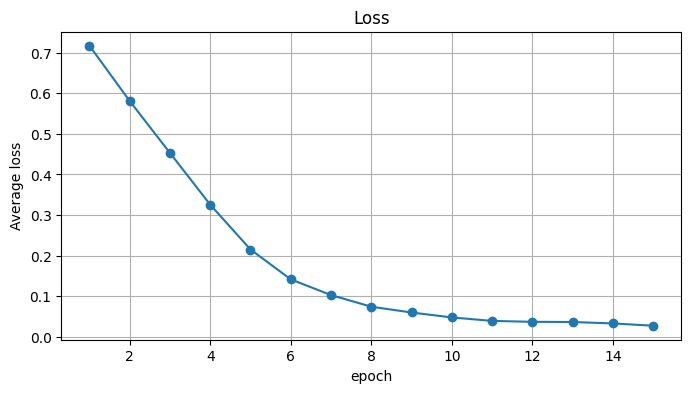

In [ ]:
plt.figure(figsize=(8,4))
plt.plot(range(1, number + 1), losses, marker='o')
plt.title("Loss")
plt.xlabel("epoch")
plt.ylabel("Average loss")
plt.grid(True)
plt.show()


# Test Dataset & DataLoader

In [ ]:
test_dataset = FOMODataset(
     image_dir=ei_export_dir,          # ora rel_path="testing/…" è risolto correttamente
     annotation_file="annotations_test.json",
     downscale=8,
     )
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)



In [ ]:
# Pruning
apply_pruning_to_model(model, amount=0.3)

for module in model.modules():
    if isinstance(module, torch.nn.Conv2d):
        try:
            prune.remove(module, 'weight')
        except Exception:
            pass

##
model.eval()

# Conv2d+ ReLu fusion
model_fused = torch.quantization.fuse_modules(
    model,
    [['head.0', 'head.1']],  # fusion Conv + ReLU dans ta tête
    inplace=False
)

# Quantization
model_fused.qconfig = torch.quantization.get_default_qconfig('fbgemm')
torch.quantization.prepare(model_fused, inplace=True)

# Calibration
for i, (imgs, _) in enumerate(loader):
    model_fused(imgs)
    if i >= 5:  # calibrer sur 5 batches
        break

quantized_model = torch.quantization.convert(model_fused, inplace=False)

# Save
torch.save(quantized_model.state_dict(), 'fomo_model_ptq.pth')

import os
MEM1 = os.path.getsize("fomo_model_ptq.pth") / (1024)
print("Poids du modèle (KB):",MEM1 )



/usr/local/lib/python3.11/dist-packages/torch/ao/quantization/observer.py:229: UserWarning: Please use quant_min and quant_max to specify the range for observers.                     reduce_range will be deprecated in a future release of PyTorch.
  warnings.warn(


Poids du modèle (KB): 42.251953125


=== Metrics ===

True Positives: 39, False Positives: 0, False Negatives: 8

Accuracy: 1.00, Rappel: 0.83, F1-score: 0.91

Average distance: 2.25 pixels

Angle + distance accuracy: 0.79

== End of inference ==

RAM used (MB): 712.3515625


# Fine tuning

Epoch 1/6   Loss: 0.0307
Epoch 2/6   Loss: 0.0280
Epoch 3/6   Loss: 0.0242
Epoch 4/6   Loss: 0.0188
Epoch 5/6   Loss: 0.0189
Epoch 6/6   Loss: 0.0162


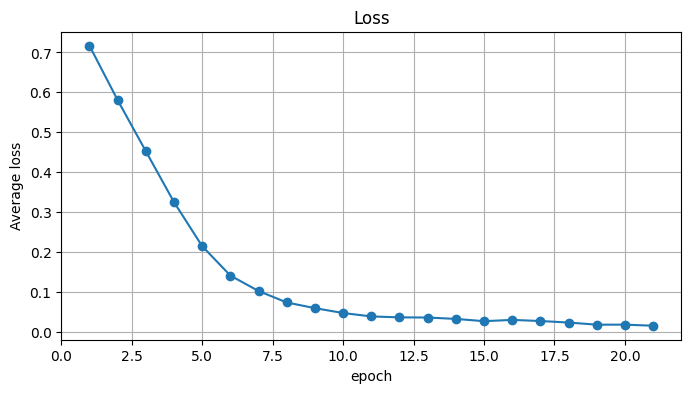

Poids du modèle (KB): 42.251953125


In [ ]:
number = 6
model.train()
for epoch in range(number):
    total_loss = 0.0
    for imgs, hms in loader:
        preds = model(imgs)           # [B,1,20,20]
        loss  = fomo_loss(preds, hms)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    avg = total_loss / len(loader)
    losses.append(avg)
    print(f"Epoch {epoch+1}/{number}   Loss: {avg:.4f}")
import matplotlib.pyplot as plt

plt.figure(figsize=(8,4))
plt.plot(range(1, 15+number + 1), losses, marker='o')
plt.title("Loss")
plt.xlabel("epoch")
plt.ylabel("Average loss")
plt.grid(True)
plt.show()


test_dataset = FOMODataset(
     image_dir=ei_export_dir,          # ora rel_path="testing/…" è risolto correttamente
     annotation_file="annotations_test.json",
     downscale=8,
     )
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

# Pruning
apply_pruning_to_model(model, amount=0.3)

for module in model.modules():
    if isinstance(module, torch.nn.Conv2d):
        try:
            prune.remove(module, 'weight')
        except Exception:
            pass

##
model.eval()

# Conv2d+ ReLu fusion
model_fused = torch.quantization.fuse_modules(
    model,
    [['head.0', 'head.1']],  # fusion Conv + ReLU dans ta tête
    inplace=False
)

# Quantization
model_fused.qconfig = torch.quantization.get_default_qconfig('fbgemm')
torch.quantization.prepare(model_fused, inplace=True)

# Calibration
for i, (imgs, _) in enumerate(loader):
    model_fused(imgs)
    if i >= 5:  # calibrer sur 5 batches
        break

quantized_model = torch.quantization.convert(model_fused, inplace=False)

# Save
torch.save(quantized_model.state_dict(), 'fomo_model_ptq.pth')

import os
MEM1 = os.path.getsize("fomo_model_ptq.pth") / (1024)
print("Poids du modèle (KB):",MEM1 )

=== Metrics ===

True Positives: 47, False Positives: 0, False Negatives: 0

Accuracy: 1.00, Rappel: 1.00, F1-score: 1.00

Average distance: 2.64 pixels

Angle + distance accuracy: 0.94

== End of inference ==

RAM used (MB): 734.06640625

# Inference Loop with Bounding Box Comparison

beam_250cm_45.0deg_141326.png.5trrnivb.ingestion-675c9d8db9-7mmq4.jpg
  GT bbox: (57, 28, 27, 24)
  GT center pixel: (71.4, 41.0)
  Pred center px: (70.0, 34.0)


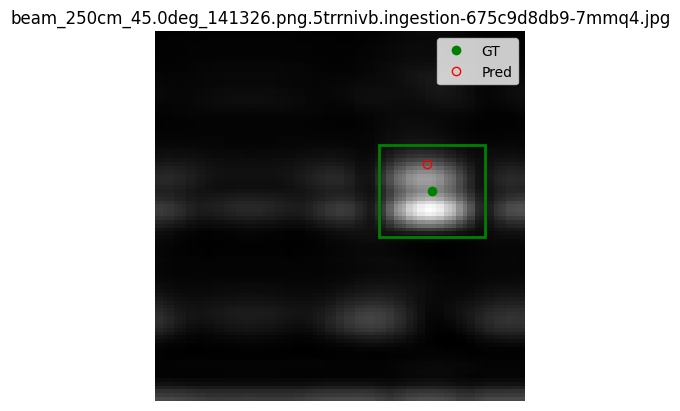

beam_250cm_45.0deg_141544.png.5trrnivc.ingestion-675c9d8db9-bmp5p.jpg
  GT bbox: (57, 28, 26, 23)
  GT center pixel: (71.2, 40.2)
  Pred center px: (70.0, 42.0)


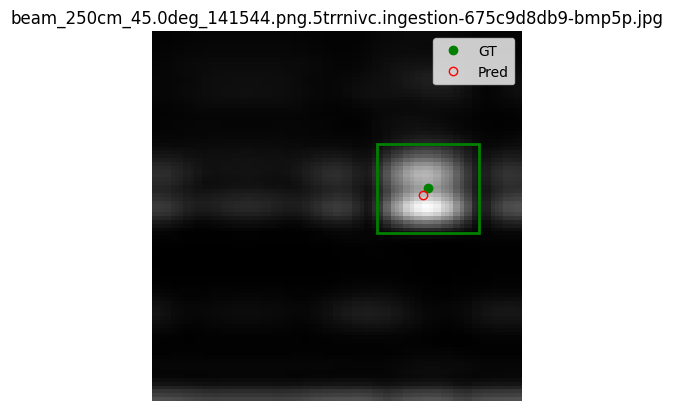

beam_250cm_45.0deg_141000.png.5trrnivd.ingestion-675c9d8db9-7mmq4.jpg
  GT bbox: (57, 28, 26, 23)
  GT center pixel: (71.2, 40.5)
  Pred center px: (70.0, 34.0)


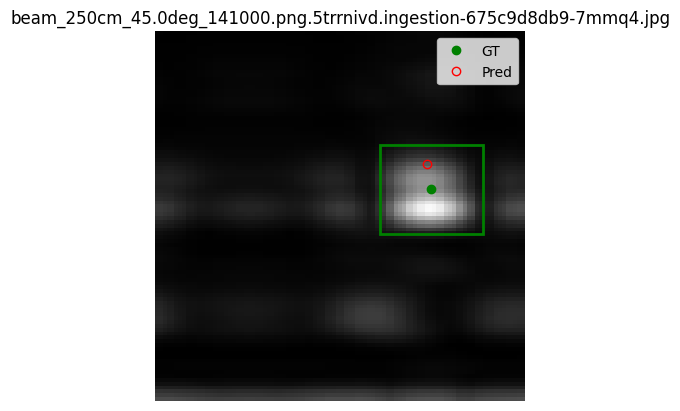

beam_250cm_67.5deg_142129.png.5trrniva.ingestion-675c9d8db9-7mmq4.jpg
  GT bbox: (73, 28, 22, 22)
  GT center pixel: (84.9, 40.1)
  Pred center px: (86.0, 42.0)


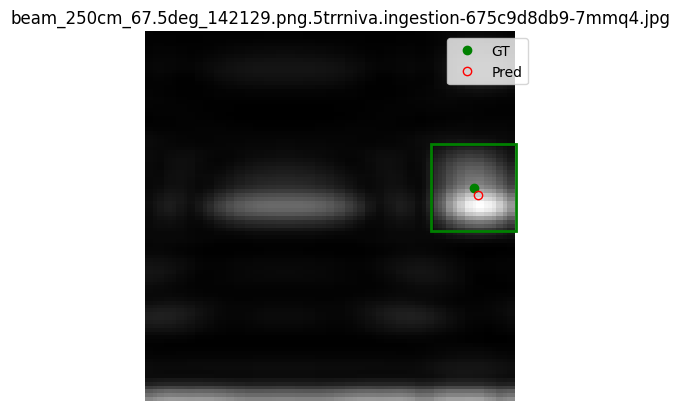

beam_250cm_22.5deg_140535.png.5trrnivd.ingestion-675c9d8db9-567st.jpg
  GT bbox: (38, 27, 31, 26)
  GT center pixel: (54.3, 40.5)
  Pred center px: (51.3, 40.7)


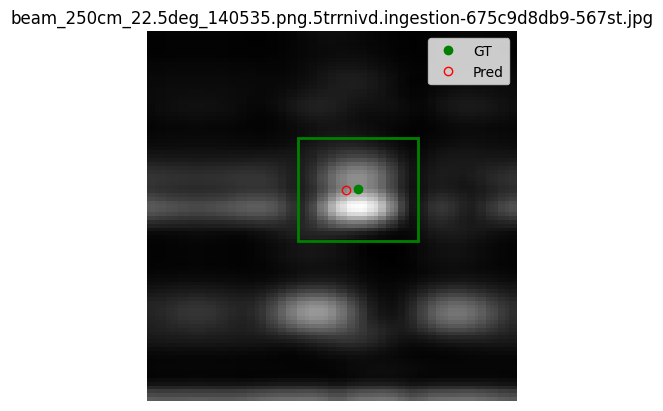

beam_250cm_22.5deg_140358.png.5trrnivb.ingestion-675c9d8db9-7mmq4.jpg
  GT bbox: (38, 27, 31, 26)
  GT center pixel: (54.3, 40.5)
  Pred center px: (51.3, 40.7)


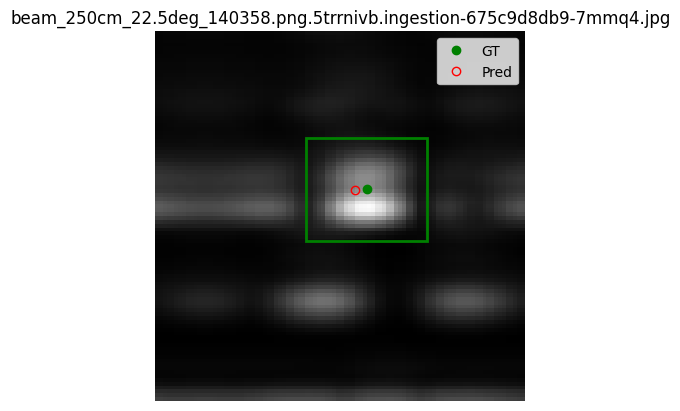

beam_250cm_45.0deg_141217.png.5trrnivd.ingestion-675c9d8db9-567st.jpg
  GT bbox: (54, 27, 31, 27)
  GT center pixel: (70.5, 41.1)
  Pred center px: (70.0, 42.0)


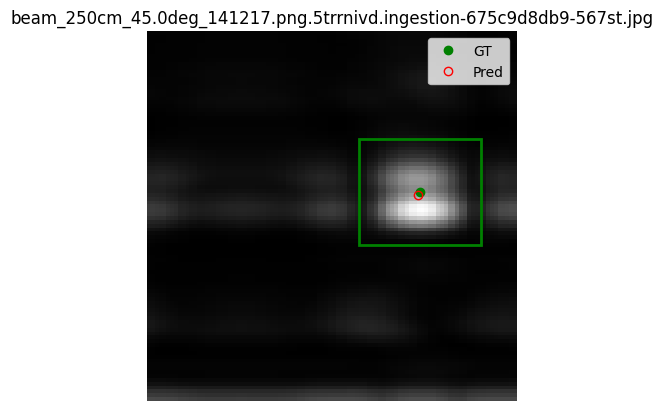

beam_250cm_67.5deg_141658.png.5trrnivd.ingestion-675c9d8db9-bmp5p.jpg
  GT bbox: (69, 27, 26, 28)
  GT center pixel: (82.8, 41.1)
  Pred center px: (86.0, 38.0)


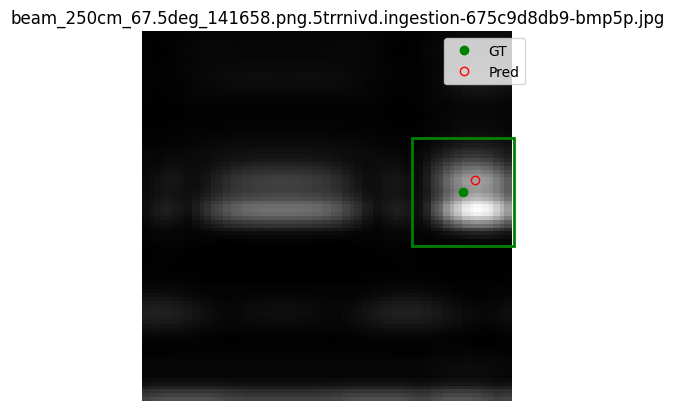

beam_250cm_67.5deg_141912.png.5trrnivb.ingestion-675c9d8db9-567st.jpg
  GT bbox: (69, 27, 25, 27)
  GT center pixel: (82.7, 40.7)
  Pred center px: (86.0, 42.0)


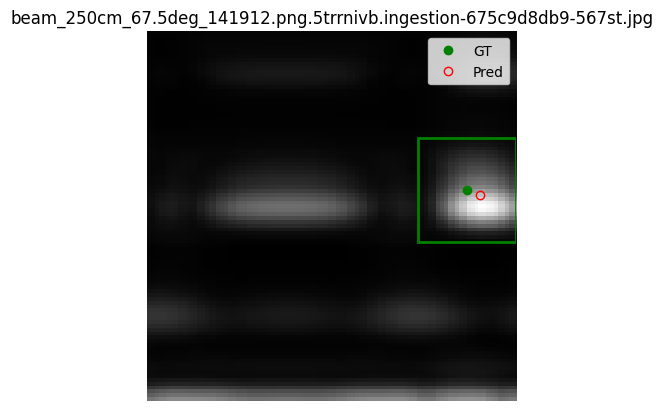

beam_350cm_67.5deg_135625.png.5trrnivs.ingestion-675c9d8db9-567st.jpg
  GT bbox: (69, 9, 25, 27)
  GT center pixel: (82.7, 22.6)
  Pred center px: (85.0, 22.0)


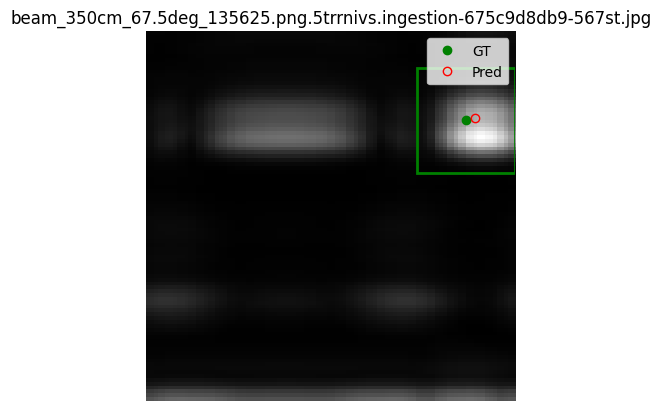

beam_250cm_45.0deg_141109.png.5trrnivd.ingestion-675c9d8db9-bmp5p.jpg
  GT bbox: (56, 26, 27, 29)
  GT center pixel: (70.0, 41.1)
  Pred center px: (70.0, 42.0)


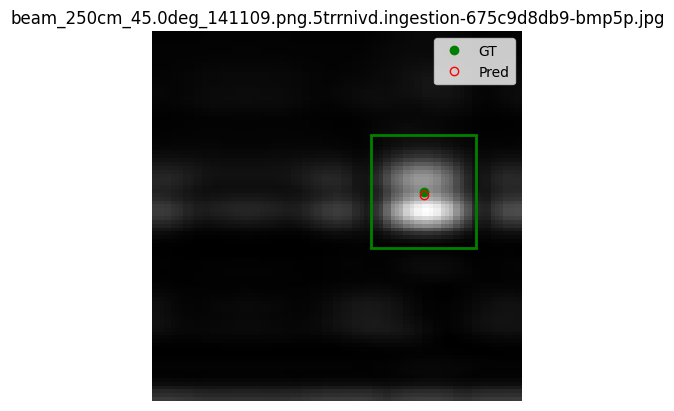

beam_250cm_22.5deg_140140.png.5trrnivb.ingestion-675c9d8db9-567st.jpg
  GT bbox: (39, 24, 28, 31)
  GT center pixel: (54.0, 39.6)
  Pred center px: (52.7, 39.3)


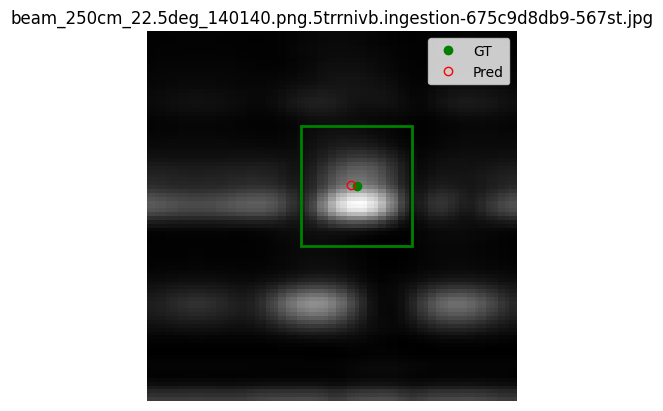

beam_250cm_67.5deg_141805.png.5trrnivb.ingestion-675c9d8db9-7mmq4.jpg
  GT bbox: (70, 25, 25, 30)
  GT center pixel: (83.5, 40.8)
  Pred center px: (86.0, 40.0)


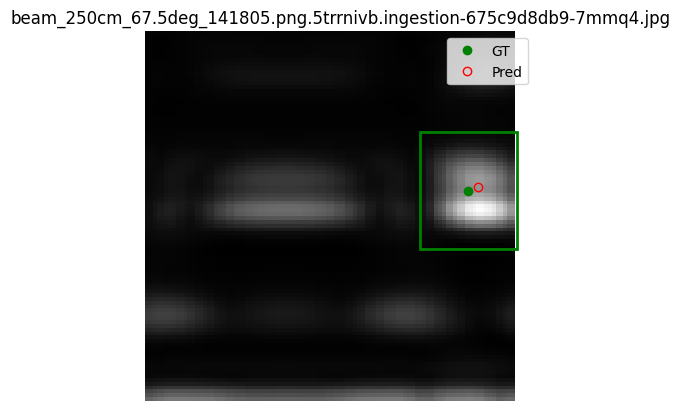

beam_250cm_45.0deg_141436.png.5trrnivc.ingestion-675c9d8db9-567st.jpg
  GT bbox: (55, 25, 25, 30)
  GT center pixel: (68.0, 40.5)
  Pred center px: (70.0, 40.0)


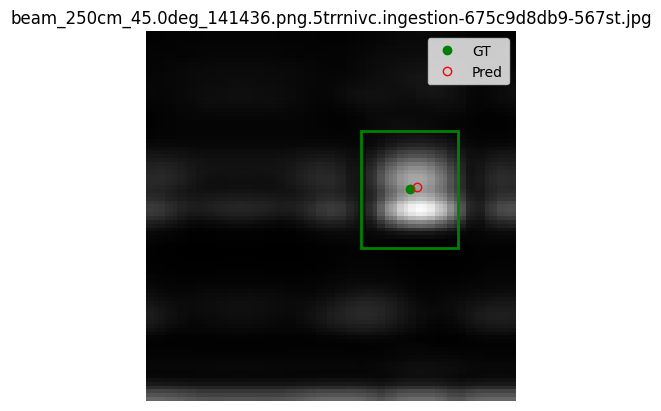

beam_250cm_22.5deg_140031.png.5trrnivs.ingestion-675c9d8db9-7mmq4.jpg
  GT bbox: (39, 23, 25, 31)
  GT center pixel: (52.2, 39.0)
  Pred center px: (52.7, 39.3)


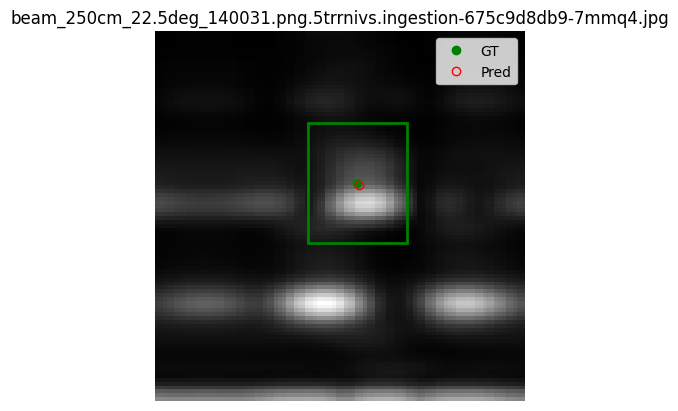

beam_350cm_67.5deg_135518.png.5trrnivs.ingestion-675c9d8db9-7mmq4.jpg
  GT bbox: (69, 5, 26, 31)
  GT center pixel: (82.5, 21.8)
  Pred center px: (85.0, 22.0)


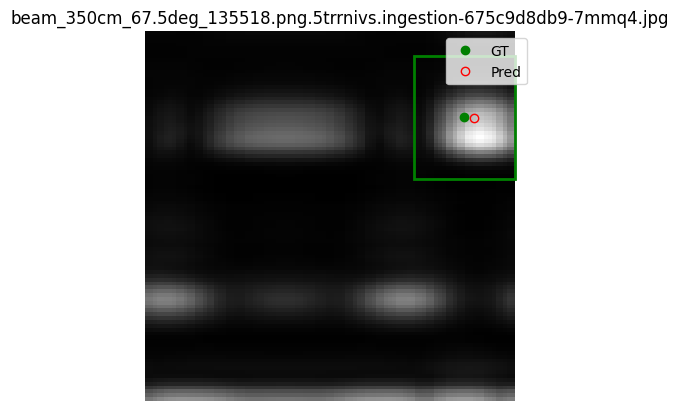

beam_350cm_67.5deg_135411.png.5trrnivt.ingestion-675c9d8db9-bmp5p.jpg
  GT bbox: (69, 4, 26, 33)
  GT center pixel: (82.5, 21.5)
  Pred center px: (86.0, 22.0)


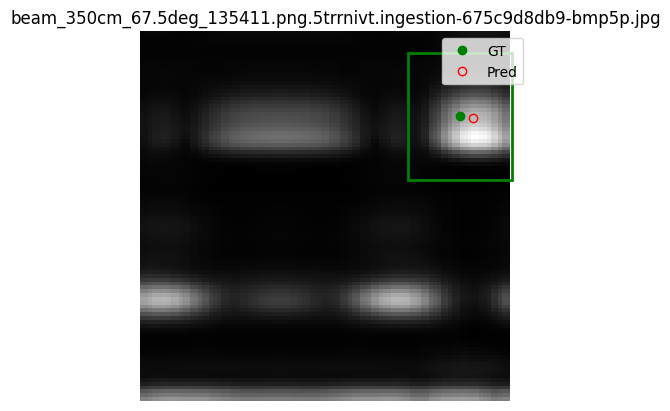

beam_350cm_67.5deg_135249.png.5trrnivu.ingestion-675c9d8db9-567st.jpg
  GT bbox: (69, 4, 26, 33)
  GT center pixel: (82.5, 21.5)
  Pred center px: (85.0, 22.0)


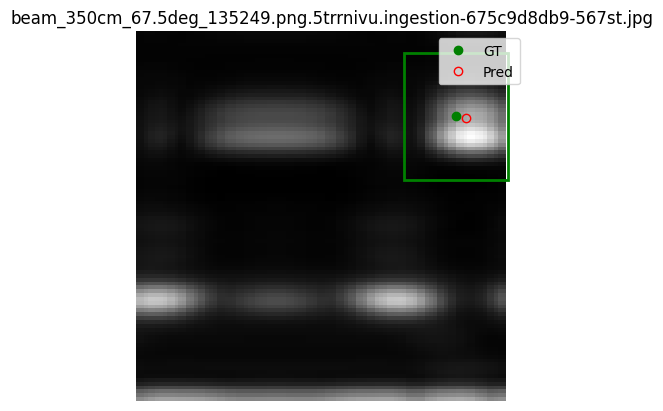

beam_250cm_67.5deg_142020.png.5trrniva.ingestion-675c9d8db9-bmp5p.jpg
  GT bbox: (69, 23, 26, 33)
  GT center pixel: (82.5, 39.6)
  Pred center px: (86.0, 42.0)


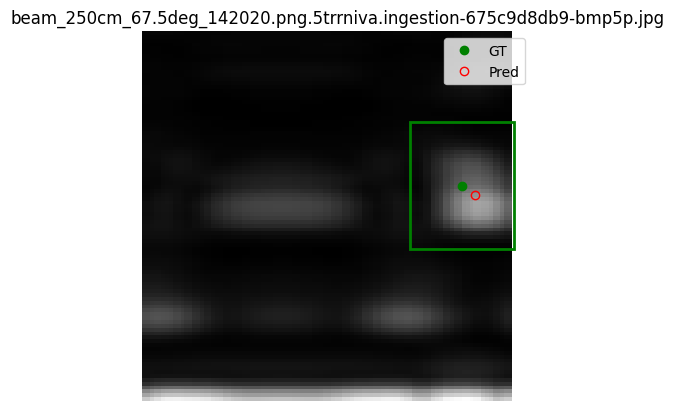

beam_250cm_22.5deg_140249.png.5trrnivr.ingestion-675c9d8db9-bmp5p.jpg
  GT bbox: (41, 22, 25, 31)
  GT center pixel: (54.5, 38.3)
  Pred center px: (52.0, 40.0)


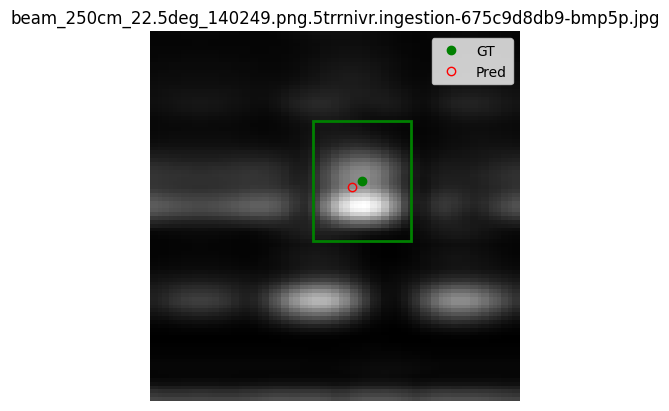

beam_350cm_67.5deg_135142.png.5trrnjea.ingestion-675c9d8db9-bmp5p.jpg
  GT bbox: (71, 3, 24, 32)
  GT center pixel: (83.9, 19.9)
  Pred center px: (85.0, 22.0)


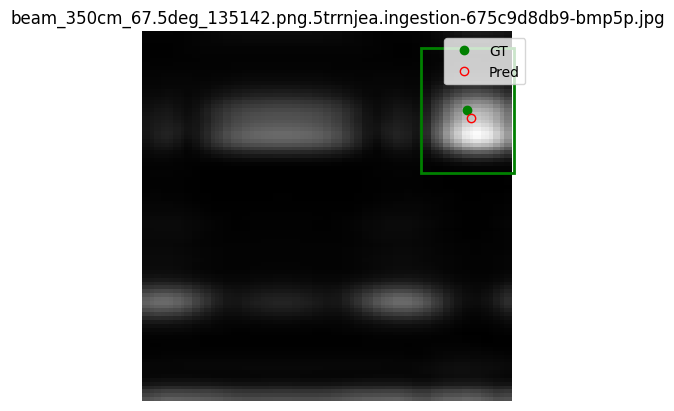

beam_350cm_45.0deg_134905.png.5trrnjed.ingestion-675c9d8db9-567st.jpg
  GT bbox: (56, 3, 27, 32)
  GT center pixel: (70.5, 19.8)
  Pred center px: (70.0, 22.0)


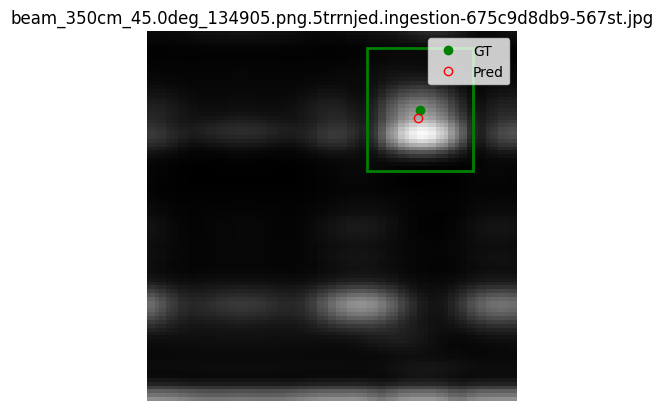

beam_350cm_22.5deg_134107.png.5trrnjf1.ingestion-675c9d8db9-567st.jpg
  GT bbox: (41, 2, 27, 32)
  GT center pixel: (55.0, 18.2)
  Pred center px: (52.0, 22.0)


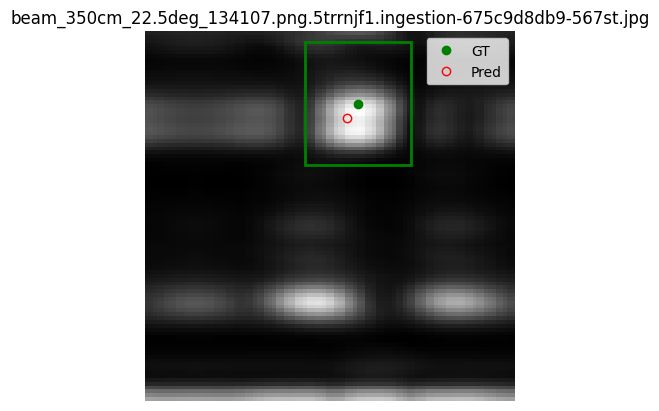

beam_350cm_45.0deg_134722.png.5trrnjed.ingestion-675c9d8db9-bmp5p.jpg
  GT bbox: (56, 2, 28, 32)
  GT center pixel: (70.1, 18.9)
  Pred center px: (68.0, 22.0)


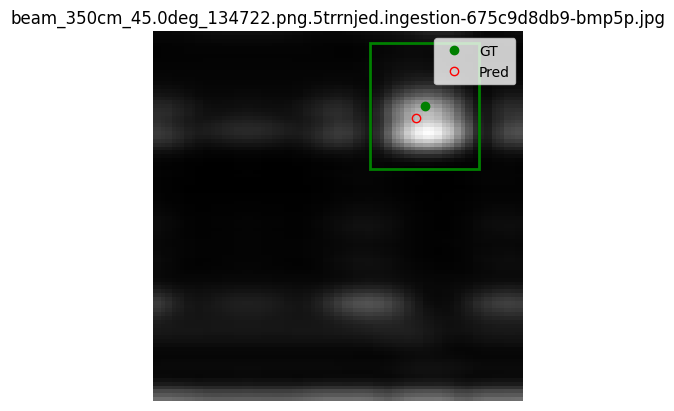

beam_350cm_45.0deg_134501.png.5trrnjev.ingestion-675c9d8db9-567st.jpg
  GT bbox: (56, 2, 28, 32)
  GT center pixel: (70.1, 18.9)
  Pred center px: (68.7, 20.7)


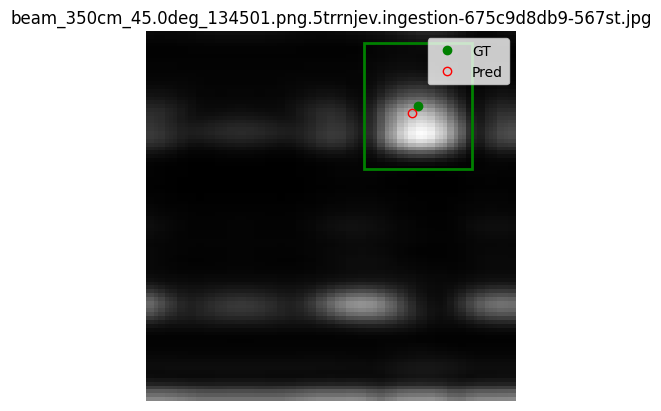

beam_350cm_22.5deg_133849.png.5trrnjf2.ingestion-675c9d8db9-567st.jpg
  GT bbox: (40, 1, 27, 31)
  GT center pixel: (53.9, 17.6)
  Pred center px: (52.0, 22.0)


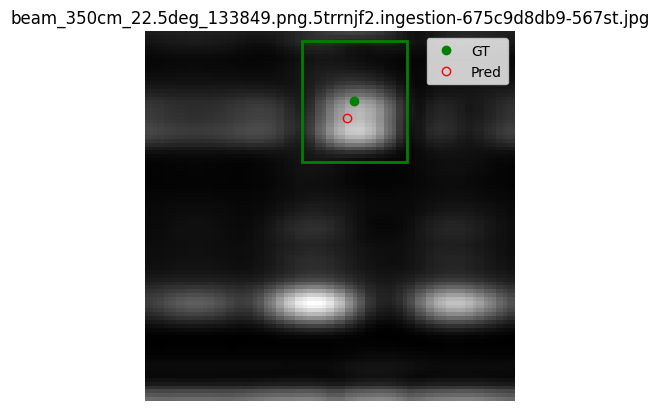

beam_150cm_45.0deg_132927.png.5trrnjf9.ingestion-675c9d8db9-567st.jpg
  GT bbox: (56, 48, 26, 24)
  GT center pixel: (70.3, 61.2)
  Pred center px: (68.0, 62.0)


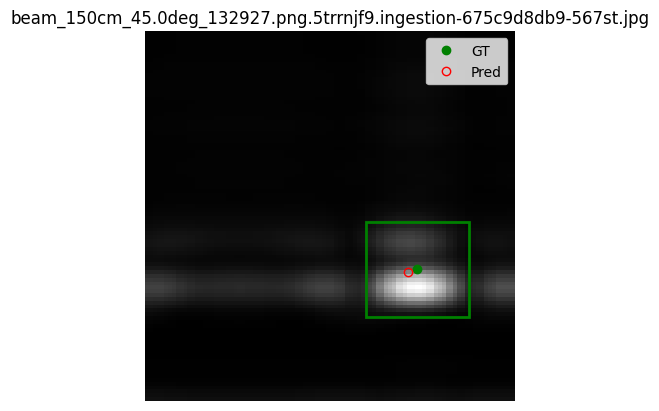

beam_350cm_45.0deg_134610.png.5trrnjef.ingestion-675c9d8db9-7mmq4.jpg
  GT bbox: (56, 9, 27, 25)
  GT center pixel: (70.8, 22.8)
  Pred center px: (70.0, 22.0)


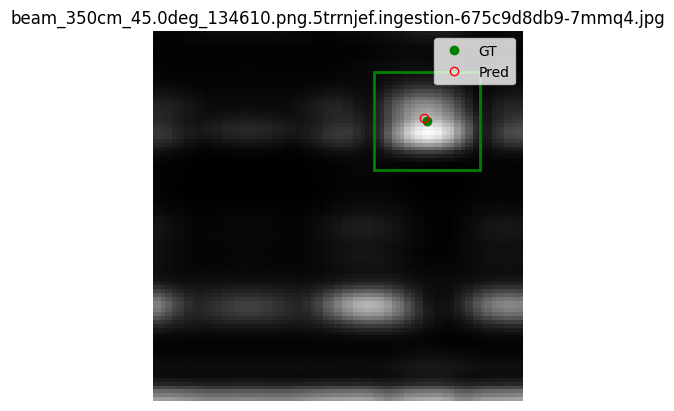

beam_150cm_45.0deg_132706.png.5trrnjfm.ingestion-675c9d8db9-7mmq4.jpg
  GT bbox: (56, 48, 27, 24)
  GT center pixel: (70.5, 60.9)
  Pred center px: (72.0, 62.0)


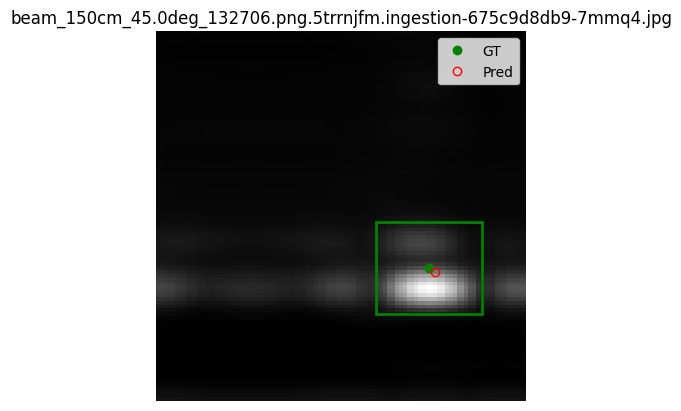

beam_150cm_45.0deg_132819.png.5trrnjfa.ingestion-675c9d8db9-bmp5p.jpg
  GT bbox: (56, 48, 27, 24)
  GT center pixel: (70.5, 60.9)
  Pred center px: (72.0, 62.0)


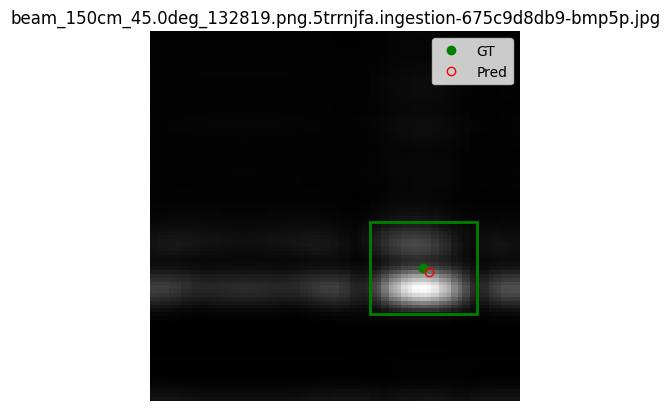

beam_150cm_67.5deg_133322.png.5trrnjf3.ingestion-675c9d8db9-567st.jpg
  GT bbox: (73, 48, 22, 24)
  GT center pixel: (84.5, 60.9)
  Pred center px: (84.7, 63.3)


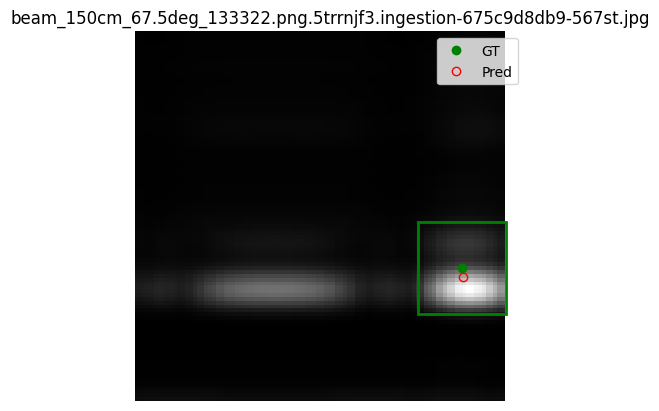

beam_150cm_67.5deg_133537.png.5trrnjf2.ingestion-675c9d8db9-bmp5p.jpg
  GT bbox: (73, 48, 22, 23)
  GT center pixel: (84.4, 60.8)
  Pred center px: (84.7, 60.7)


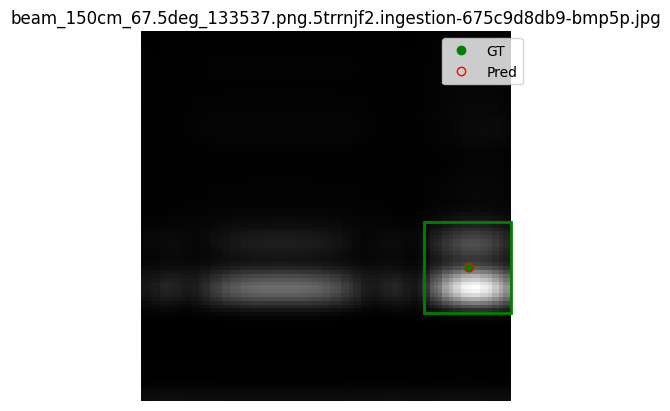

beam_350cm_22.5deg_134221.png.5trrnjfj.ingestion-675c9d8db9-7mmq4.jpg
  GT bbox: (39, 9, 30, 24)
  GT center pixel: (55.0, 21.5)
  Pred center px: (53.0, 19.0)


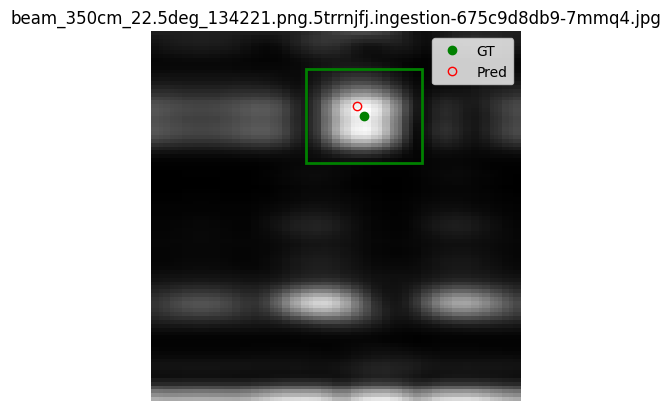

beam_150cm_67.5deg_133214.png.5trrnjf5.ingestion-675c9d8db9-bmp5p.jpg
  GT bbox: (74, 48, 21, 27)
  GT center pixel: (85.3, 62.5)
  Pred center px: (86.0, 62.0)


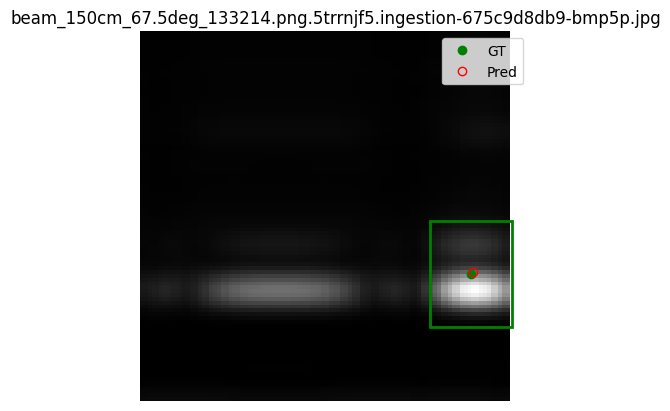

beam_350cm_45.0deg_135031.png.5trrnjed.ingestion-675c9d8db9-7mmq4.jpg
  GT bbox: (54, 10, 31, 24)
  GT center pixel: (70.5, 22.8)
  Pred center px: (68.7, 20.7)


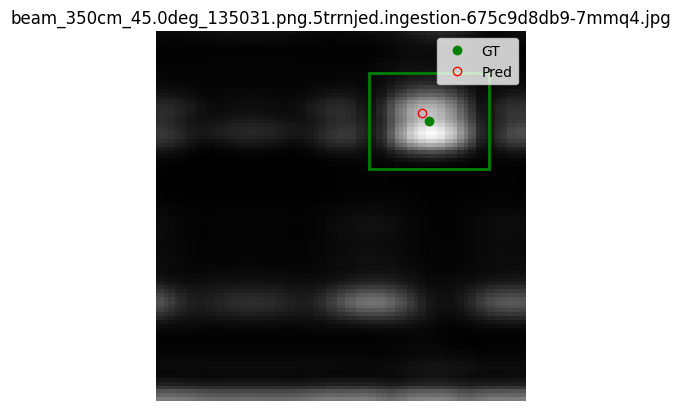

beam_150cm_45.0deg_133033.png.5trrnjfl.ingestion-675c9d8db9-7mmq4.jpg
  GT bbox: (54, 48, 30, 24)
  GT center pixel: (69.8, 60.6)
  Pred center px: (68.0, 62.0)


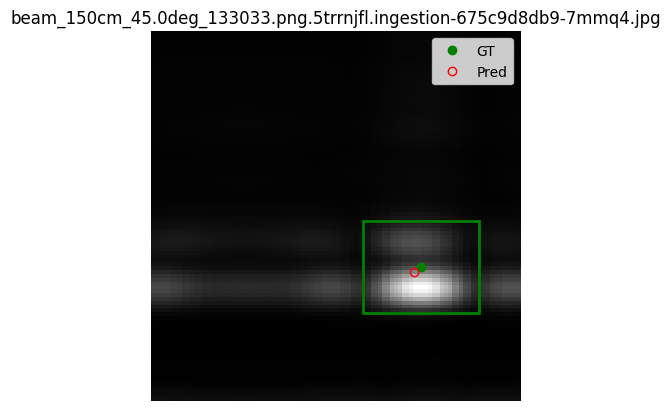

beam_150cm_67.5deg_133644.png.5trrnjfj.ingestion-675c9d8db9-7mmq4.jpg
  GT bbox: (70, 48, 25, 24)
  GT center pixel: (83.5, 60.6)
  Pred center px: (84.0, 62.0)


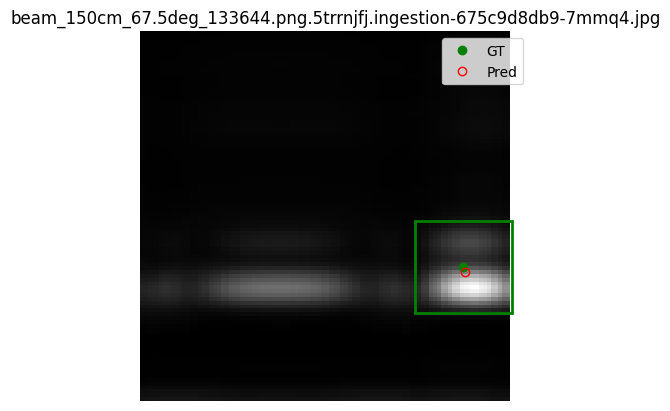

beam_350cm_22.5deg_134350.png.5trrnjev.ingestion-675c9d8db9-bmp5p.jpg
  GT bbox: (41, 9, 25, 24)
  GT center pixel: (54.3, 21.4)
  Pred center px: (52.0, 22.0)


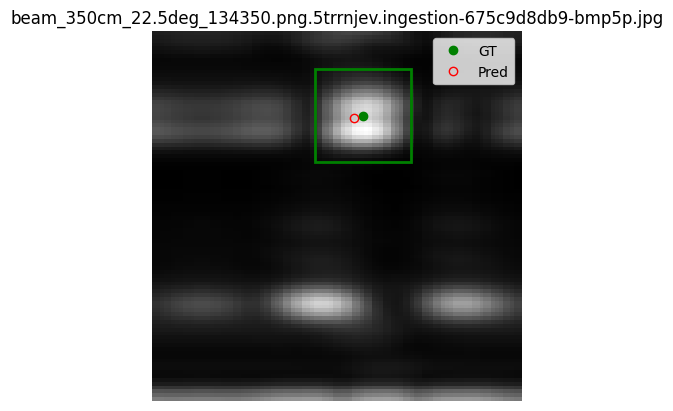

beam_150cm_67.5deg_133429.png.5trrnjfk.ingestion-675c9d8db9-7mmq4.jpg
  GT bbox: (72, 49, 23, 26)
  GT center pixel: (84.2, 62.5)
  Pred center px: (84.0, 62.0)


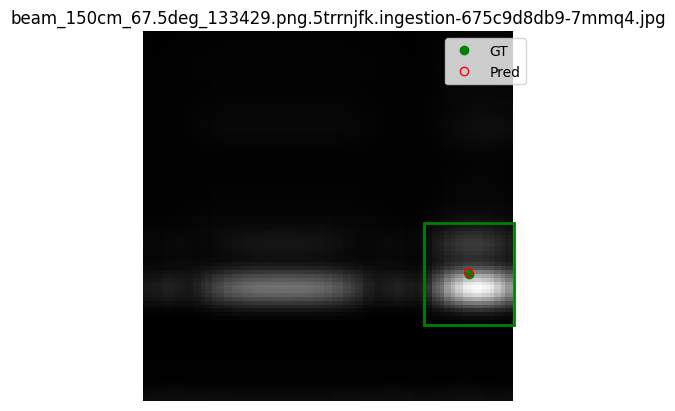

beam_350cm_22.5deg_133958.png.5trrnjf1.ingestion-675c9d8db9-bmp5p.jpg
  GT bbox: (38, 7, 31, 27)
  GT center pixel: (54.2, 21.0)
  Pred center px: (52.0, 22.0)


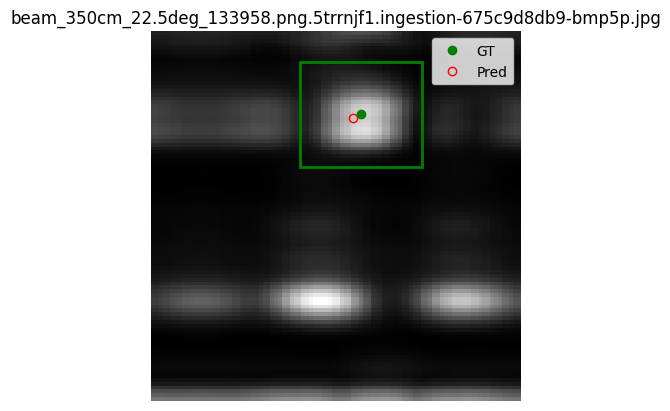

beam_150cm_45.0deg_132558.png.5trrnke7.ingestion-675c9d8db9-bmp5p.jpg
  GT bbox: (56, 46, 26, 27)
  GT center pixel: (69.8, 59.8)
  Pred center px: (68.0, 62.0)


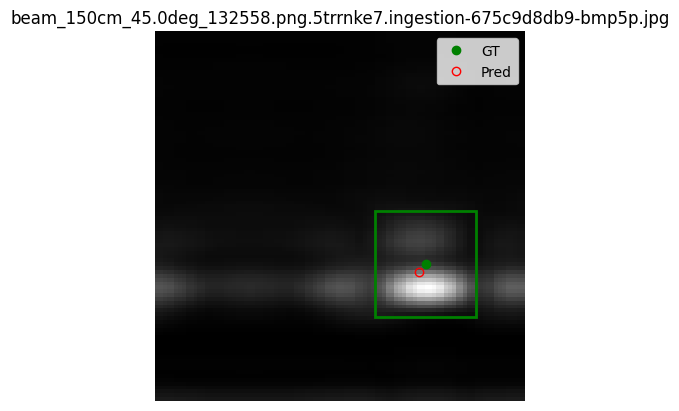

beam_150cm_22.5deg_131716.png.5trrnkm4.ingestion-675c9d8db9-bmp5p.jpg
  GT bbox: (41, 45, 26, 27)
  GT center pixel: (54.7, 59.5)
  Pred center px: (56.0, 62.0)


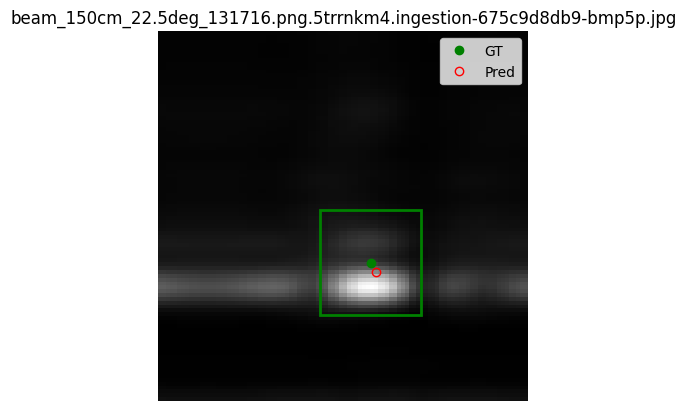

beam_150cm_22.5deg_131934.png.5trrnkm3.ingestion-675c9d8db9-7mmq4.jpg
  GT bbox: (40, 45, 26, 27)
  GT center pixel: (54.0, 59.5)
  Pred center px: (51.3, 60.7)


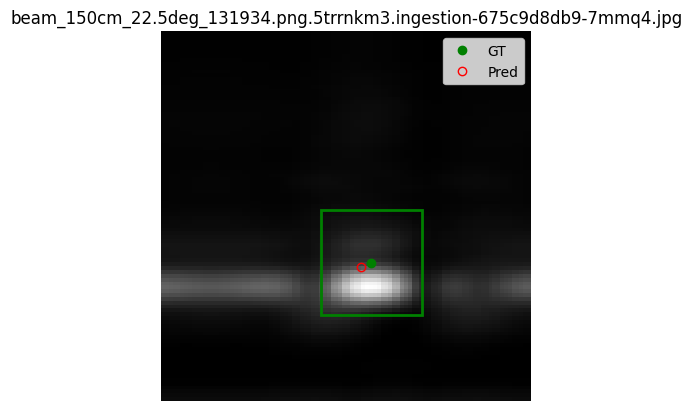

beam_150cm_22.5deg_131826.png.5trrnkm4.ingestion-675c9d8db9-567st.jpg
  GT bbox: (40, 45, 26, 27)
  GT center pixel: (54.0, 59.5)
  Pred center px: (52.0, 60.0)


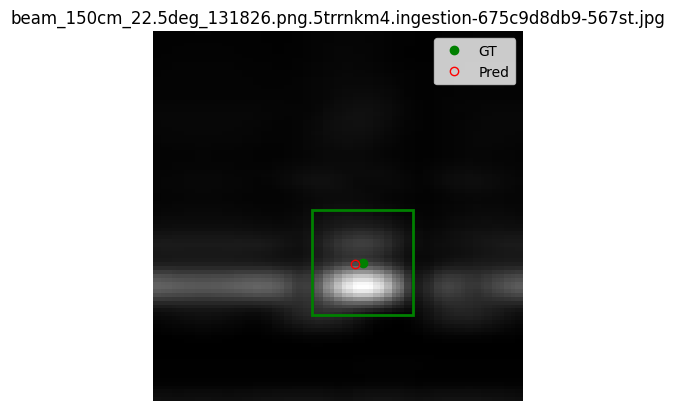

beam_150cm_22.5deg_132333.png.5trrnkm3.ingestion-675c9d8db9-567st.jpg
  GT bbox: (40, 45, 28, 29)
  GT center pixel: (54.8, 60.3)
  Pred center px: (58.0, 62.0)


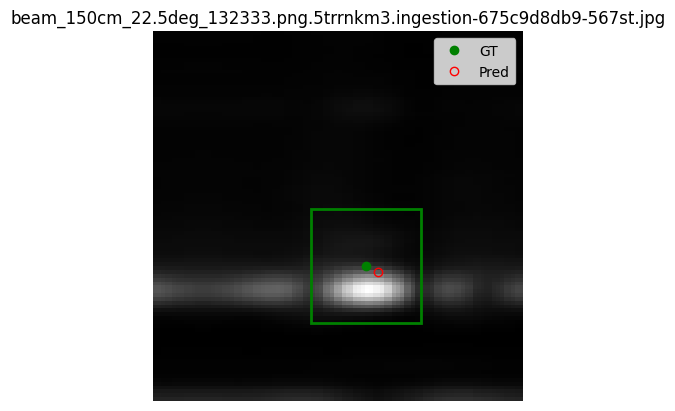

beam_150cm_22.5deg_132105.png.5trrnkm3.ingestion-675c9d8db9-bmp5p.jpg
  GT bbox: (40, 45, 26, 28)
  GT center pixel: (54.3, 59.8)
  Pred center px: (52.0, 62.0)


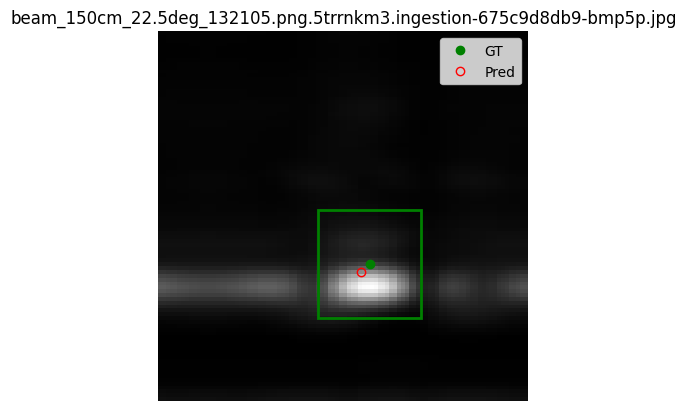

beam_150cm_22.5deg_131559.png.5trrnkoe.ingestion-675c9d8db9-567st.jpg
  GT bbox: (40, 44, 27, 28)
  GT center pixel: (54.0, 58.6)
  Pred center px: (52.7, 59.3)


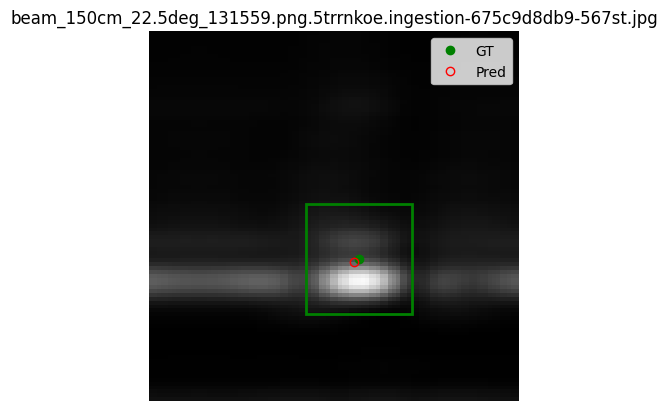


=== Metrics ===
True Positives: 47, False Positives: 0, False Negatives: 0
Accuracy: 1.00, Rappel: 1.00, F1-score: 1.00
Average distance: 2.64 pixels
Angle + distance accuracy: 0.94
== End of inference ==
RAM used (MB): 734.06640625


In [ ]:
from math import sqrt

threshold = 10  # pixels
tp = fp = fn = 0
total_dist = 0
count = 0

correct_angle = correct_dist = 0
correct_both = 0
total_valid = 0


quantized_model.eval()
with torch.no_grad():
    for batch_idx, (imgs, hms) in enumerate(test_loader):
        start_idx = batch_idx * test_loader.batch_size
        outs = model(imgs)
        preds = (outs > 0.5).squeeze(1).cpu().numpy().astype(bool)


        for i in range(len(preds)):
            rel_path = test_dataset.names[start_idx + i]
            filename = os.path.basename(rel_path)
            polar = extract_polar_from_filename(filename)


            img_tensor = imgs[i].cpu()
            img_np = img_tensor.permute(1, 2, 0).numpy()
            H_img, W_img = img_np.shape[:2]

            print(f"{filename}")

            # Ground-truth bbox from JSON annotations
            if rel_path in test_annotations and len(test_annotations[rel_path]) > 0:
                gt_box = test_annotations[rel_path][0]
                gt_x0, gt_y0, gt_w, gt_h = gt_box
                cx = gt_x0 + gt_w / 2
                cy = gt_y0 + gt_h / 2
                bbox_size = max(gt_w, gt_h)
                print(f"  GT bbox: ({int(gt_x0)}, {int(gt_y0)}, {int(gt_w)}, {int(gt_h)})")
                print(f"  GT center pixel: ({cx:.1f}, {cy:.1f})")
            else:
                print("  GT bbox info: N/A")
                gt_x0 = gt_y0 = gt_w = gt_h = -1
                cx = cy = -1
                bbox_size = 40

            # Centroid accuracy
            centroid = get_largest_blob_centroid(preds[i], (H_img, W_img), preds[i].shape)
            if centroid is not None:
                cx_p, cy_p = centroid
                print(f"  Pred center px: ({cx_p:.1f}, {cy_p:.1f})")
            else:
                print("  Predicted: No object found")
                total_valid += 1 # because we always have someone in the radar image
            # Evaluation
            if centroid is not None and cx >= 0:
                dist_px = sqrt((cx - cx_p)**2 + (cy - cy_p)**2)
                total_dist += dist_px
                count += 1
                if dist_px < threshold:
                    tp += 1
                else:
                    fp += 1
            elif centroid is not None:
                fp += 1
            elif cx >= 0:
                fn += 1
            if centroid is not None and cx >= 0:
                pred_dist_cm, pred_angle_deg = pixel_to_polar(cx_p, cy_p, (H_img, W_img))
                # true_dist_cm, true_angle_deg = pixel_to_polar(cx, cy, (H_img, W_img))

                pred_dist_class = assign_to_nearest(pred_dist_cm, valid_distances)
                # true_dist_class = assign_to_nearest(true_dist_cm, valid_distances)

                pred_angle_class = assign_to_nearest(pred_angle_deg, valid_angles)
                # true_angle_class = assign_to_nearest(true_angle_deg, valid_angles)

                true_dist_class, true_angle_class = polar
                if pred_dist_class == true_dist_class and pred_angle_class == true_angle_class:
                    correct_both += 1
                total_valid += 1
            # Visualisation
            fig, ax = plt.subplots()
            ax.imshow(img_np)

            # GT bbox rectangle + center
            if gt_x0 >= 0:
                ax.add_patch(plt.Rectangle((gt_x0, gt_y0), gt_w, gt_h,
                                           edgecolor='green', facecolor='none', linewidth=2))
                ax.plot(cx, cy, 'go',label='GT')

            # Accuracy center
            if centroid is not None:
                ax.plot(cx_p, cy_p, 'ro',markerfacecolor='none', label='Pred')

            ax.set_title(filename)
            ax.legend(loc='upper right')
            ax.axis('off')
            plt.show()
    precision = tp / (tp + fp + 1e-6)
    recall = tp / (tp + fn + 1e-6)
    f1 = 2 * precision * recall / (precision + recall + 1e-6)
    avg_dist = total_dist / count if count > 0 else float('inf')

    print("\n=== Metrics ===")
    print(f"True Positives: {tp}, False Positives: {fp}, False Negatives: {fn}")
    print(f"Accuracy: {precision:.2f}, Rappel: {recall:.2f}, F1-score: {f1:.2f}")
    print(f"Average distance: {avg_dist:.2f} pixels")

    accuracy_polar_class = correct_both / total_valid if total_valid > 0 else 0
    print(f"Angle + distance accuracy: {accuracy_polar_class:.2f}")
print("== End of inference ==")
RAM1=psutil.Process().memory_info().rss / (1024 * 1024)
print("RAM used (MB):",RAM1 )

#save and size


In [ ]:
!pip install onnx

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.6/17.6 MB 86.8 MB/s eta 0:00:00


In [ ]:
dummy_input = torch.randn(1, 3, 96, 96)
torch.onnx.export(model_fused, dummy_input, "fomo96_final.onnx", opset_version=11)
from google.colab import files
files.download("fomo96_final.onnx")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>